# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P1_REINFORCE_VS_GA.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P1_REINFORCE_VS_GA.ipynb)

# HW3: REINFORCE Vs. GA
> - Full Name: **[Mohammadjavad Ahmadpour]**
> - Student ID: **[400104697]**


This notebook implements a Grid World environment where an agent learns to navigate from a start position to a goal while avoiding penalties. It compares two learning approaches:

1. REINFORCE Algorithm (Policy Gradient)
2. Genetic Algorithm

Follow the instructions in each section to complete the homework.

**Grading Breakdown:**

- Practical Implementation: 60 points
- Conceptual Understanding: 40 points

# Setup

All required packages are pre-installed if using Google Colab.

Import the following libraries.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


# Environment (10 Points)

### GridWorld Class Definition (10 Points)

In [13]:
# Grid World Parameters
GRID_SIZE = 7

# TODO: Specify the penalty locations on the Grid World. The number of penalty locations must be 8. {(x_1, y_1): penalty_reward, .... , (x_8, y_8): penalty_reward}
PENALTIES = {
    (1, 1): -10,
    (2, 2): -10,
    (3, 1): -10,
    (5, 4): -10,
    (0, 3): -10,
    (3, 6): -10,
    (5, 3): -10,
    (4, 2): -10
}

# TODO: Specify the goal location.
GOAL = (6, 6)

#  TODO: Properly assign values to the following rewards.
GOAL_REWARD = 30
STEP_PENALTY = -1
BOUNDARY_PENALTY = -2

ACTIONS = ['up', 'down', 'left', 'right']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

### GridWorld Environmnet Definition

In [14]:
class GridWorld:
    def step(self, state, action):
        x, y = state
        new_x, new_y = x, y

        if action == 'right':
            new_x = min(x + 1, GRID_SIZE - 1)
        elif action == 'left':
            new_x = max(x - 1, 0)
        elif action == 'up':
            new_y = min(y + 1, GRID_SIZE - 1)
        elif action == 'down':
            new_y = max(y - 1, 0)

        reward = STEP_PENALTY
        if (new_x, new_y) == (x, y):
            reward += BOUNDARY_PENALTY
        if (new_x, new_y) in PENALTIES:
            reward += PENALTIES[(new_x, new_y)]
        if (new_x, new_y) == GOAL:
            reward += GOAL_REWARD

        return (new_x, new_y), reward

### Initialize the Grid World

In [15]:
grid_world = GridWorld()

### Plot Empty Grid World

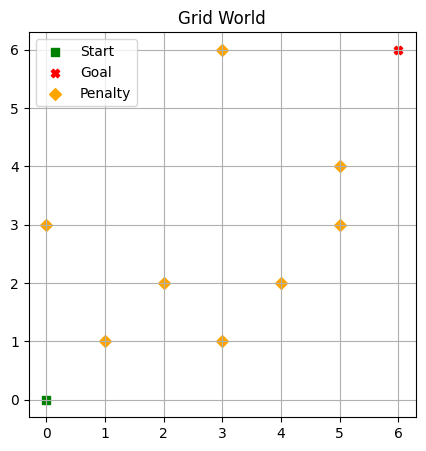

In [16]:
plt.figure(figsize=(5, 5))
plt.scatter(0, 0, c='green', marker='s', label='Start')
plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
for i, (px, py) in enumerate(PENALTIES):
    if i == 0:
        plt.scatter(px, py, c='orange', marker='D', label='Penalty')
    else:
        plt.scatter(px, py, c='orange', marker='D')
plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Grid World")
plt.legend()
plt.grid(True)
plt.show()

# REINFORCE Algorithm (30 Points)

The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

### Policy Network Definition (10 points)

In [17]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # ToDo
        self.fc2 = nn.Linear(hidden_dim, output_dim) # ToDo

    def forward(self, state):
        x = torch.relu(self.fc1(state))  # ToDo
        return torch.log_softmax(self.fc2(x), dim=-1)  # ToDo


### REINFORCE Agent Implementation (20 Points)

In [18]:
from tqdm import tqdm

class ReinforceAgent:
    def __init__(self, lr=0.005, gamma=0.99, device=device):
        self.device = device
        self.input_dim = 2    # ToDo
        self.output_dim = 4   # ToDo
        self.hidden_dim = 128   # ToDo
        self.policy_net = PolicyNetwork(self.input_dim, self.output_dim, self.hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma

    def train(self, episodes=6000, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01):
        for episode in range(episodes):
            state = (0, 0)
            trajectory, rewards = [], []

            while state != GOAL:
                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
                log_action_probs = self.policy_net(state_tensor).detach().cpu().numpy()
                action_probs = np.exp(log_action_probs)

                random_value = random.random()  # TODO: Generate a random number between 0 and 1.

                # Using an epsilon-greedy strategy to balance exploration & exploitation:
                if random_value < epsilon:
                    # TODO: Choose a random action (exploration) -> random choice from ACTIONS.
                    action = random.choice(ACTIONS)  # ToDo
                else:
                    # TODO: Choose the action with the highest probability (exploitation).
                    best_action_index = np.argmax(action_probs)  # Todo
                    # print(best_action_index)
                    action = ACTIONS[best_action_index]

                # TODO: Take a step in the Grid World based on the chosen action.
                next_state, reward = grid_world.step(state, action)

                # TODO: Store the current state, action taken, and received reward in the trajectory.
                trajectory.append((state, action, reward))

                # TODO: Record the reward to calculate returns later.
                rewards.append(reward)

                # TODO: Update the state to the new position for the next step.
                state = next_state

            returns, G = [], 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)

            returns = torch.tensor(returns, dtype=torch.float32)
            baseline = returns.mean()
            returns -= baseline

            loss = 0
            for (state, action, _), G in zip(trajectory, returns):
                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
                log_action_probs = self.policy_net(state_tensor)
                loss -= log_action_probs[ACTION_IDX[action]] * G

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epsilon = max(min_epsilon, epsilon * epsilon_decay)

            if episode % 50 == 0:
                print(f"Episode {episode}: Total Reward = {sum(rewards)}, Epsilon = {epsilon:.4f}")

    def get_optimal_trajectory(self):
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        while state != GOAL:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
            log_action_probs = self.policy_net(state_tensor).detach().cpu().numpy()
            action_probs = np.exp(log_action_probs)
            action = np.random.choice(ACTIONS, p=action_probs / action_probs.sum())
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
        return trajectory, rewards

# Genetic Algorithm


Genetic Algorithms (GAs) are optimization algorithms inspired by **natural selection**. They evolve a population of candidate solutions over multiple generations to find an optimal or near-optimal solution.

#### **1. Population ($P$)**
A **population** consists of multiple candidate solutions (individuals). Each individual represents a **policy or solution** encoded as a chromosome.

$$[
P_t = \{ X_1^t, X_2^t, ..., X_N^t \}
]$$

where:
- $( P_t )$ is the population at generation $( t )$,
- $( X_i^t )$ is the $( i )$-th individual in the population,
- $( N )$ is the population size.

#### **2. Fitness Function ($F$)**
Each individual is evaluated using a **fitness function**, which measures how good a solution is.

$$[
F(X_i) = \text{reward or performance score of } X_i
]$$

#### **3. Selection**
The best individuals are selected based on their fitness scores to produce the next generation. Common methods include:
- **Roulette Wheel Selection** (Probability proportional to fitness)
- **Tournament Selection** (Select the best out of a subset)

#### **4. Crossover (Recombination)**
Two parents **combine genetic information** to create offspring. A common method is **single-point crossover**, where a random crossover point is chosen.

$$
\begin{aligned}
\text{Parent 1} &= (A_1, A_2, | A_3, A_4, A_5) \\
\text{Parent 2} &= (B_1, B_2, | B_3, B_4, B_5) \\
\text{Offspring 1} &= (A_1, A_2, | B_3, B_4, B_5) \\
\text{Offspring 2} &= (B_1, B_2, | A_3, A_4, A_5)
\end{aligned}
$$

#### **5. Mutation**
Mutation introduces small **random changes** in individuals to maintain diversity and avoid local optima. If $( X_i )$ is an individual, a mutation function $( M )$ alters some genes:

$$[
X_i' = M(X_i)
]$$

For example, if an individual’s policy is `['up', 'right', 'down']`, mutation might randomly change `right` to `left`.

#### **6. Generations & Evolution**
The new population is formed after selection, crossover, and mutation. The process repeats for **multiple generations** until a stopping criterion is met (e.g., max generations or convergence).

$$[
P_{t+1} = \text{next\_generation}(P_t)
]$$



### Genetic Algorithm Implementation

In [19]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, policy_network, generations=100, device=device):
        self.device = device
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.policy_network = policy_network.to(self.device)  # Move the model to GPU
        self.population = [self._initialize_individual() for _ in range(population_size)]

    def _initialize_individual(self):
        # Initialize an individual by setting random weights for the policy network
        individual = {}
        for name, param in self.policy_network.named_parameters():
            individual[name] = torch.randn_like(param).to(self.device)  # Move individual weights to GPU
        return individual

    def _evaluate_individual(self, individual):
        # Simulate the evaluation (for example, run a few episodes in GridWorld environment)
        self._apply_individual_weights(individual)
        state = (0, 0)
        STOP = 0
        trajectory, rewards = [], []
        while state != GOAL and STOP <= 150:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)  # Move state to GPU
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()  # Get action with highest probability
            action = ACTIONS[action_idx]  # Map action index back to action
            new_state, reward = grid_world.step(state, action)
            trajectory.append((state, action, reward))
            rewards.append(reward)
            state = new_state
            STOP += 1
        return sum(rewards)

    def _apply_individual_weights(self, individual):
        # Apply the weights of an individual to the policy network
        for name, param in individual.items():
            self.policy_network.state_dict()[name].copy_(param)

    def _select_parents(self):
        # Select two individuals based on fitness (higher reward is better)
        scores = [(ind, self._evaluate_individual(ind)) for ind in self.population]
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        parent1 = sorted_scores[0][0]
        parent2 = sorted_scores[1][0]
        return parent1, parent2

    def _crossover(self, parent1, parent2):
        # Perform crossover to combine the genetic material of two parents
        child = {}
        for name in parent1.keys():
            if random.random() < self.crossover_rate:
                child[name] = parent1[name]
            else:
                child[name] = parent2[name]
        return child

    def _mutate(self, individual):
        # Perform mutation (randomly modify the weights)
        for name, param in individual.items():
            if random.random() < self.mutation_rate:
                individual[name] = torch.randn_like(param).to(self.device)  # Ensure mutated weight is on GPU
        return individual

    def run(self):
        for generation in tqdm(range(self.generations)):
            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self._select_parents()
                child1 = self._crossover(parent1, parent2)
                child2 = self._crossover(parent2, parent1)
                new_population.append(self._mutate(child1))
                new_population.append(self._mutate(child2))
            self.population = new_population
            print(f"Generation {generation + 1} completed")

    def get_optimal_trajectory(self):
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        STOP = 0
        while state != GOAL and STOP <= 150:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)  # Move state to GPU
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()  # Get action with highest probability
            action = ACTIONS[action_idx]  # Map action index back to action
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
            STOP += 1
        return trajectory, rewards

# Running & Comparing Agents (20 Points)

In [21]:
# Train REINFORCE agent

LEARNING_RATE = 0.001  # ToDo
GAMMA = 0.97          # ToDo

reinforce_agent = ReinforceAgent(lr = LEARNING_RATE, gamma = GAMMA)
reinforce_agent.train(episodes=7000, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.05)

Episode 0: Total Reward = -353, Epsilon = 0.9995
Episode 50: Total Reward = -1741, Epsilon = 0.9748
Episode 100: Total Reward = -208, Epsilon = 0.9507
Episode 150: Total Reward = -2068, Epsilon = 0.9273
Episode 200: Total Reward = -242, Epsilon = 0.9044
Episode 250: Total Reward = -238, Epsilon = 0.8820
Episode 300: Total Reward = -192, Epsilon = 0.8602
Episode 350: Total Reward = -238, Epsilon = 0.8390
Episode 400: Total Reward = -321, Epsilon = 0.8183
Episode 450: Total Reward = -36, Epsilon = 0.7981
Episode 500: Total Reward = -381, Epsilon = 0.7784
Episode 550: Total Reward = -347, Epsilon = 0.7591
Episode 600: Total Reward = -606, Epsilon = 0.7404
Episode 650: Total Reward = -97, Epsilon = 0.7221
Episode 700: Total Reward = -42, Epsilon = 0.7043
Episode 750: Total Reward = -143, Epsilon = 0.6869
Episode 800: Total Reward = -85, Epsilon = 0.6699
Episode 850: Total Reward = -809, Epsilon = 0.6534
Episode 900: Total Reward = -526, Epsilon = 0.6372
Episode 950: Total Reward = -249, Ep

In [22]:
# Train Genetic Algorithm agent

POPULATION_SIZE = 50  # ToDo
GENERATIONS = 50      # ToDo
MUTATION_RATE = 0.1    # ToDo
CROSSOVER_RATE = 0.5   # ToDo

policy_network = PolicyNetwork(input_dim=2, output_dim=len(ACTIONS), hidden_dim=128)
genetic_agent = GeneticAlgorithm(generations=GENERATIONS, population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, crossover_rate=CROSSOVER_RATE, policy_network=policy_network, device=device)
optimal_genetic_policy = genetic_agent.run()

  2%|▏         | 1/50 [00:25<20:46, 25.43s/it]

Generation 1 completed


  4%|▍         | 2/50 [00:50<20:18, 25.38s/it]

Generation 2 completed


  6%|▌         | 3/50 [01:16<19:54, 25.42s/it]

Generation 3 completed


  8%|▊         | 4/50 [01:43<19:58, 26.05s/it]

Generation 4 completed


 10%|█         | 5/50 [02:08<19:27, 25.94s/it]

Generation 5 completed


 12%|█▏        | 6/50 [02:34<18:58, 25.88s/it]

Generation 6 completed


 14%|█▍        | 7/50 [03:00<18:35, 25.93s/it]

Generation 7 completed


 16%|█▌        | 8/50 [03:26<18:04, 25.81s/it]

Generation 8 completed


 18%|█▊        | 9/50 [03:53<17:54, 26.20s/it]

Generation 9 completed


 20%|██        | 10/50 [04:20<17:43, 26.60s/it]

Generation 10 completed


 22%|██▏       | 11/50 [04:46<17:01, 26.19s/it]

Generation 11 completed


 24%|██▍       | 12/50 [05:11<16:24, 25.92s/it]

Generation 12 completed


 26%|██▌       | 13/50 [05:36<15:52, 25.75s/it]

Generation 13 completed


 28%|██▊       | 14/50 [06:02<15:22, 25.63s/it]

Generation 14 completed


 30%|███       | 15/50 [06:27<14:54, 25.57s/it]

Generation 15 completed


 32%|███▏      | 16/50 [06:52<14:24, 25.42s/it]

Generation 16 completed


 34%|███▍      | 17/50 [07:19<14:15, 25.92s/it]

Generation 17 completed


 36%|███▌      | 18/50 [07:45<13:43, 25.73s/it]

Generation 18 completed


 38%|███▊      | 19/50 [08:10<13:13, 25.60s/it]

Generation 19 completed


 40%|████      | 20/50 [08:37<12:58, 25.96s/it]

Generation 20 completed


 42%|████▏     | 21/50 [09:02<12:26, 25.73s/it]

Generation 21 completed


 44%|████▍     | 22/50 [09:27<11:57, 25.63s/it]

Generation 22 completed


 46%|████▌     | 23/50 [09:46<10:36, 23.59s/it]

Generation 23 completed


 48%|████▊     | 24/50 [09:52<07:52, 18.16s/it]

Generation 24 completed


 50%|█████     | 25/50 [09:58<06:04, 14.60s/it]

Generation 25 completed


 52%|█████▏    | 26/50 [10:04<04:51, 12.14s/it]

Generation 26 completed


 54%|█████▍    | 27/50 [10:13<04:18, 11.22s/it]

Generation 27 completed


 56%|█████▌    | 28/50 [10:20<03:34,  9.76s/it]

Generation 28 completed


 58%|█████▊    | 29/50 [10:27<03:08,  8.97s/it]

Generation 29 completed


 60%|██████    | 30/50 [10:33<02:43,  8.16s/it]

Generation 30 completed


 62%|██████▏   | 31/50 [10:41<02:31,  7.95s/it]

Generation 31 completed


 64%|██████▍   | 32/50 [10:47<02:13,  7.42s/it]

Generation 32 completed


 66%|██████▌   | 33/50 [10:55<02:12,  7.81s/it]

Generation 33 completed


 68%|██████▊   | 34/50 [11:03<02:01,  7.62s/it]

Generation 34 completed


 70%|███████   | 35/50 [11:08<01:43,  6.91s/it]

Generation 35 completed


 72%|███████▏  | 36/50 [11:15<01:36,  6.86s/it]

Generation 36 completed


 74%|███████▍  | 37/50 [11:23<01:33,  7.18s/it]

Generation 37 completed


 76%|███████▌  | 38/50 [11:29<01:24,  7.01s/it]

Generation 38 completed


 78%|███████▊  | 39/50 [11:37<01:20,  7.30s/it]

Generation 39 completed


 80%|████████  | 40/50 [11:45<01:14,  7.48s/it]

Generation 40 completed


 82%|████████▏ | 41/50 [11:51<01:04,  7.16s/it]

Generation 41 completed


 84%|████████▍ | 42/50 [11:57<00:53,  6.74s/it]

Generation 42 completed


 86%|████████▌ | 43/50 [12:05<00:49,  7.12s/it]

Generation 43 completed


 88%|████████▊ | 44/50 [12:14<00:45,  7.66s/it]

Generation 44 completed


 90%|█████████ | 45/50 [12:26<00:44,  8.93s/it]

Generation 45 completed


 92%|█████████▏| 46/50 [12:34<00:34,  8.58s/it]

Generation 46 completed


 94%|█████████▍| 47/50 [12:41<00:24,  8.04s/it]

Generation 47 completed


 96%|█████████▌| 48/50 [12:50<00:16,  8.38s/it]

Generation 48 completed


 98%|█████████▊| 49/50 [12:57<00:07,  7.98s/it]

Generation 49 completed


100%|██████████| 50/50 [13:04<00:00, 15.69s/it]

Generation 50 completed


# Visualizing Results (40 Points)

Plots the agent’s trajectory in the Grid World.

In [23]:
def visualize_trajectory(trajectory, title):
    plt.figure(figsize=(5, 5))
    x_vals, y_vals = zip(*trajectory)
    plt.plot(x_vals, y_vals, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.scatter(0, 0, c='green', marker='s', label='Start')
    plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
    for i, (px, py) in enumerate(PENALTIES):
        if i == 0:
            plt.scatter(px, py, c='orange', marker='D', label='Penalty')
        else:
            plt.scatter(px, py, c='orange', marker='D')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Results

Final Reward (REINFORCE): 18



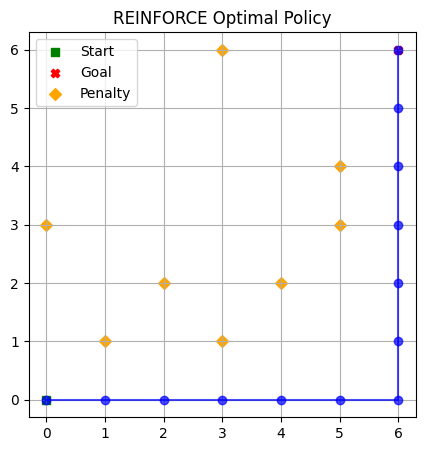


--------------------------------------------------------------------------------------

Final Reward (Genetic Algorithm): 8



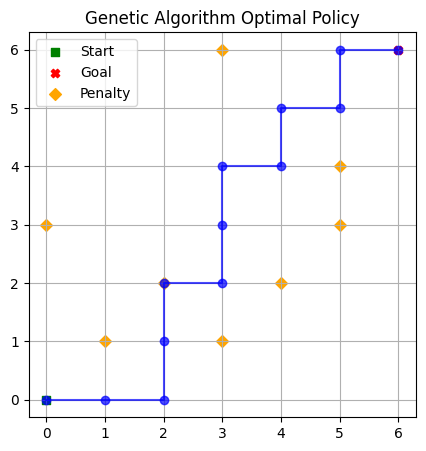

In [24]:
# Results

optimal_reinforce_trajectory, final_reward_reinforce = reinforce_agent.get_optimal_trajectory()
print(f"Final Reward (REINFORCE): {final_reward_reinforce}\n")
visualize_trajectory(optimal_reinforce_trajectory, "REINFORCE Optimal Policy")

print("\n--------------------------------------------------------------------------------------\n")

optimal_genetic_trajectory, final_reward_genetic = genetic_agent.get_optimal_trajectory()
print(f"Final Reward (Genetic Algorithm): {final_reward_genetic}\n")
visualize_trajectory(optimal_genetic_trajectory, "Genetic Algorithm Optimal Policy")

$\bullet$ Based on the implementation and results from comparing policy search using Genetic Algorithm (GA) and the REINFORCE algorithm:

**Question 1:** (10 points)

How do these two methods differ in terms of their effectiveness for solving reinforcement learning tasks?

**Question 2:** (15 points)

Discuss the key differences in their **performance**, **convergence rates**, and **stability**.

**Question 3:** (15 points)

Additionally, explore how each method handles exploration and exploitation, and suggest situations where one might be preferred over the other.

In doc
<br/>
............
<br/>
............
<br/>
............